Thanks to [Reference](https://towardsdatascience.com/missing-value-imputation-with-python-and-k-nearest-neighbors-308e7abd273d)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-dataset/data.csv


In [39]:
df = pd.read_csv('/kaggle/input/real-estate-dataset/data.csv')

In [40]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         5
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Original dataset has no missing value but I try to create null values and I will show you how I handle the missing values with KNN imputation.

In [41]:
i1 = np.random.choice(a=df.index, size=40)
i2 = np.random.choice(a=df.index, size=25)

In [42]:
df.loc[i1, 'INDUS'] = np.nan
df.loc[i2, 'TAX'] = np.nan

In [43]:
df.isnull().sum()

CRIM        0
ZN          0
INDUS      39
CHAS        0
NOX         0
RM          5
AGE         0
DIS         0
RAD         0
TAX        24
PTRATIO     0
B           0
LSTAT       0
MEDV        0
dtype: int64

# KNN imputation

In [44]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)

In [45]:
df_imputed

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.310000,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.070000,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.070000,0.0,0.469,7.185,61.1,4.9671,2.0,256.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.180000,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,3.810000,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,0.98765,0.0,12.500000,0.0,0.561,6.980,89.0,2.0980,3.0,320.0,23.0,396.00,12.00,12.0
507,0.23456,0.0,12.500000,0.0,0.561,6.980,76.0,2.6540,3.0,320.0,23.0,343.00,25.00,32.0
508,0.44433,0.0,12.500000,0.0,0.561,6.123,98.0,2.9870,3.0,320.0,23.0,343.00,21.00,54.0
509,0.77763,0.0,12.700000,0.0,0.561,6.222,34.0,2.5430,3.0,329.0,23.0,343.00,76.00,67.0


In [46]:
df_imputed.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

# Imputer optimization

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

In [48]:
def optimize_k(data, target):
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [49]:
k_errors = optimize_k(data=df, target='MEDV')
k_errors

[{'K': 1, 'RMSE': 5.17770284840756},
 {'K': 3, 'RMSE': 5.238579072518533},
 {'K': 5, 'RMSE': 5.214810162328655},
 {'K': 7, 'RMSE': 5.110090112822382},
 {'K': 9, 'RMSE': 5.28904954204935},
 {'K': 11, 'RMSE': 5.163335749130829},
 {'K': 13, 'RMSE': 5.241949634522808},
 {'K': 15, 'RMSE': 5.154467815984443},
 {'K': 17, 'RMSE': 5.061530524695786},
 {'K': 19, 'RMSE': 5.125866375266467}]

In [50]:
k_errors_df = pd.DataFrame(k_errors)
k_errors_df

,K,RMSE
0,1,5.177703
1,3,5.238579
2,5,5.214810
3,7,5.110090
4,9,5.289050
5,11,5.163336
6,13,5.241950
7,15,5.154468
8,17,5.061531
9,19,5.125866


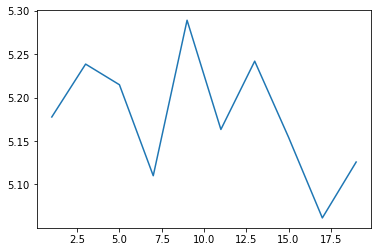

In [51]:
import matplotlib.pyplot as plt
plt.plot(k_errors_df['K'],k_errors_df['RMSE'])
plt.show()

When K=17, we have the optimal value!